In [1]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions           
from keras.preprocessing import image                                            
import numpy as np     
import glob

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
#from keras.optimizers import SGD
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D , MaxPool2D , Flatten , Dropout, MaxPooling2D

import os

import csv
import platform
import shutil
from collections import namedtuple
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.experimental import enable_halving_search_cv

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve, HalvingGridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, balanced_accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [35]:
DATA_PATH = Path("../public_data")      # Uncomment to use FULL DATASET
# DATA_PATH = Path("sample_data")         # Sample dataset

SUBM_PATH = Path("submissions")
MODEL_PATH = Path("submission_code")
SCORE_PATH = Path("scoring_output")

RESULTS_PATH = SUBM_PATH / "submission_results"

DATA_NAME = "Areal"

DATA_SETS = ["train", "valid", "test"]
ALL_SETS = ["train", "valid-lab", "valid", "test"]

In [3]:
glob.glob(os.path.join('public_data','*'))

['public_data\\Areal_feat.name',
 'public_data\\Areal_feat.type',
 'public_data\\Areal_label.name',
 'public_data\\Areal_public.info',
 'public_data\\Areal_test.data',
 'public_data\\Areal_train.data',
 'public_data\\Areal_train.solution',
 'public_data\\Areal_valid.data',
 'public_data\\mimic_synthetic_feat.name',
 'public_data\\mimic_synthetic_feat.type',
 'public_data\\mimic_synthetic_label.name',
 'public_data\\mimic_synthetic_test.data',
 'public_data\\mimic_synthetic_train.data',
 'public_data\\mimic_synthetic_train.solution']

In [4]:
def number_lines(fname):
    with open(fname) as f:
        return sum(1 for l in f)

In [5]:
def fast_import(arr, fpath):
    with open(fpath) as f:
        for i, row in enumerate(csv.reader(f, delimiter=" ")):
            arr[i] = row

In [6]:
num_fts = number_lines(DATA_PATH / f"{DATA_NAME}_feat.name")

num = {
    data_set: number_lines(DATA_PATH / f"{DATA_NAME}_{data_set}.data")
    for data_set in DATA_SETS
}

xs_raw = {
    data_set: np.empty((num[data_set], num_fts))
    for data_set in DATA_SETS
}

for data_set in DATA_SETS:
    fast_import(
        xs_raw[data_set], 
        fpath=DATA_PATH / f"{DATA_NAME}_{data_set}.data"
    )

In [7]:
xs_raw['train'].shape

(5200, 49152)

In [8]:
labels_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_label.name", header=None, names=["name"]
)

labels = labels_df.name.to_list()

ys_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_train.solution", header=None, names=["value"]
)

ys_raw = ys_df.values

ys_df["label"] = ys_df.value.map(labels_df.name)

ys_df.head()

,value,label
0,5,island
1,0,beach
2,0,beach
3,1,chaparral
4,0,beach


### Feature's types

In [9]:
features = pd.read_csv(DATA_PATH / "Areal_feat.name", header=None).values.flatten()
labels = pd.read_csv(DATA_PATH / "Areal_label.name", header=None).values.flatten()

In [10]:
types = pd.read_csv(DATA_PATH / "Areal_feat.type", header=None).set_index(features)[0]
types.value_counts()

int    49152
Name: 0, dtype: int64

### Visualize dataset sample

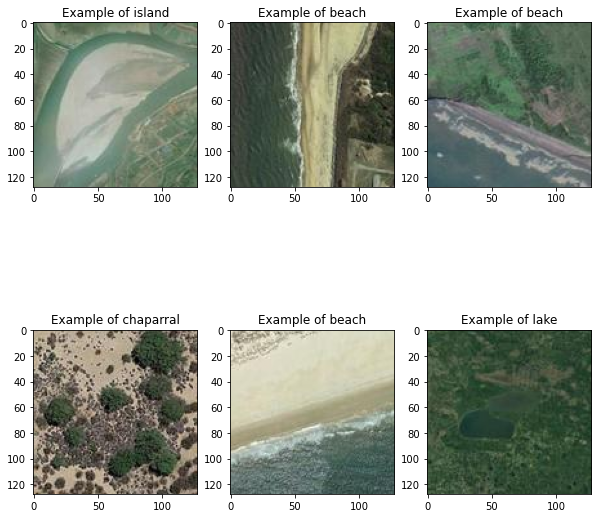

In [11]:
NUM_TO_SHOW = 6

fig, axs_ = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
axs = axs_.flatten()

for i in range(NUM_TO_SHOW):
    img = xs_raw["train"][i].reshape(128, 128, -1)
    label = ys_df.label[i]
    axs[i].set_title(f"Example of {label}")
    axs[i].imshow(img.astype(float) / 255)

plt.show()

In [12]:
ys_hot = pd.get_dummies(ys_raw.ravel())
ys_hot.shape, xs_raw['train'].shape


((5200, 13), (5200, 49152))

In [13]:
xs, ys = {}, {}

xs["train"], xs["valid"], ys["train"], ys["valid"] = train_test_split(
    xs_raw["train"], ys_hot, random_state=40)

xs["test"] = xs_raw["test"]

print(xs_raw["train"].shape, ys_hot.shape)
print(xs["train"].shape, ys["train"].shape)
print(xs["valid"].shape, ys["valid"].shape)
print(xs["test"].shape)

(5200, 49152) (5200, 13)
(3900, 49152) (3900, 13)
(1300, 49152) (1300, 13)
(1950, 49152)


In [14]:
# Normalize the data
x_train = np.array(xs['train']) / 255
x_val = np.array(xs['valid']) / 255

x_train = x_train.reshape(-1,128,128,3)
y_train = np.array(ys['train'])

x_val = x_val.reshape(-1,128,128,3)
y_val = np.array(ys['valid'])
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(3900, 128, 128, 3) (1300, 128, 128, 3) (3900, 13) (1300, 13)


Data augmentation on the train data:

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.3, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(x_train)
augmented_flow = datagen.flow(x_train, y_train, batch_size=32)

### Model CNN

* We start with the Sequential object and add the 2D Convolution layers with 32 filters (or neurons) with 3x3 kernel size.
* Our input shape for every image is to be: 128x128 pixels and 3 represents that our images are RGB.
* We define the activation function to be ‘ReLU’.
* We then add a Pooling(MaxPooling2D) layer, another convolution layer and a fully connected (Dense) layer. The Dropout layer is intended to make sure our model does not overfit.
* Our last layer is another Dense layer, also functioning as our output layer which outputs 13 class probabilities which add up to 1, with the help of the softmax activation function.

<b>Things to have in mind when using CNN to avoid overfitting: </b>

<b> 1. Simplifying The Model </b>
 
The first step when dealing with overfitting is to decrease the complexity of the model. To decrease the complexity, we can simply remove layers or reduce the number of neurons to make the network smaller. While doing this, it is important to calculate the input and output dimensions of the various layers involved in the neural network. There is no general rule on how much to remove or how large your network should be. But, if your neural network is overfitting, try making it smaller.

<b> 2. Early Stopping </b>
  
Early stopping is a form of regularization while training a model with an iterative method, such as gradient descent. Since all the neural networks learn exclusively by using gradient descent, early stopping is a technique applicable to all the problems. This method update the model so as to make it better fit the training data with each iteration. Up to a point, this improves the model’s performance on data on the test set. Past that point however, improving the model’s fit to the training data leads to increased generalization error. Early stopping rules provide guidance as to how many iterations can be run before the model begins to overfit.


<b> 3. Use Data Augmentation </b>
 
In the case of neural networks, data augmentation simply means increasing size of the data that is increasing the number of images present in the dataset. Some of the popular image augmentation techniques are flipping, translation, rotation, scaling, changing brightness, adding noise etcetera. For a more complete reference, feel free to checkout albumentations and imgaug.


<b> 4. Use Dropouts </b>
 
Dropout is a regularization technique that prevents neural networks from overfitting. Regularization methods like L1 and L2 reduce overfitting by modifying the cost function. Dropout on the other hand, modify the network itself. It randomly drops neurons from the neural network during training in each iteration. When we drop different sets of neurons, it’s equivalent to training different neural networks. The different networks will overfit in different ways, so the net effect of dropout will be to reduce overfitting. The default interpretation of the dropout hyperparameter is the probability of training a given node in a layer, where 1.0 means no dropout, and 0.0 means no outputs from the layer.
A good value for dropout in a hidden layer is between 0.5 and 0.8. Input layers use a larger dropout rate, such as of 0.8.


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
opt = Adam(lr=0.000001) 

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation = 'relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation = 'relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(1024, (3, 3), activation = 'relu', padding="same"))
model.add(Flatten())
model.add(Dense(units = 2048, activation = 'relu'))
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dense(units = 13, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [18]:
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
history = model.fit(augmented_flow, epochs = 500, callbacks=[early_stopping], validation_data = (x_val, y_val))

Epoch 1/500
122/122 [==============================] - 140s 1s/step - loss: 2.4327 - accuracy: 0.1308 - val_loss: 2.1685 - val_accuracy: 0.1708
Epoch 2/500
122/122 [==============================] - 134s 1s/step - loss: 2.0299 - accuracy: 0.2346 - val_loss: 1.8675 - val_accuracy: 0.3162
Epoch 3/500
122/122 [==============================] - 145s 1s/step - loss: 1.8954 - accuracy: 0.2823 - val_loss: 1.8020 - val_accuracy: 0.3092
Epoch 4/500
122/122 [==============================] - 141s 1s/step - loss: 1.6346 - accuracy: 0.3792 - val_loss: 1.4692 - val_accuracy: 0.4769
Epoch 5/500
122/122 [==============================] - 140s 1s/step - loss: 1.4334 - accuracy: 0.4795 - val_loss: 1.3937 - val_accuracy: 0.4977
Epoch 6/500
122/122 [==============================] - 154s 1s/step - loss: 1.3293 - accuracy: 0.5177 - val_loss: 1.3093 - val_accuracy: 0.5362
Epoch 7/500
122/122 [==============================] - 153s 1s/step - loss: 1.2465 - accuracy: 0.5556 - val_loss: 1.1584 - val_accuracy:

122/122 [==============================] - 226s 2s/step - loss: 0.4004 - accuracy: 0.8669 - val_loss: 0.4752 - val_accuracy: 0.8523
Epoch 58/500
122/122 [==============================] - 230s 2s/step - loss: 0.4071 - accuracy: 0.8600 - val_loss: 0.4146 - val_accuracy: 0.8715
Epoch 59/500
122/122 [==============================] - 233s 2s/step - loss: 0.4196 - accuracy: 0.8538 - val_loss: 0.4936 - val_accuracy: 0.8362
Epoch 60/500
122/122 [==============================] - 231s 2s/step - loss: 0.4023 - accuracy: 0.8572 - val_loss: 0.5039 - val_accuracy: 0.8423
Epoch 61/500
122/122 [==============================] - 232s 2s/step - loss: 0.3564 - accuracy: 0.8764 - val_loss: 0.4808 - val_accuracy: 0.8492
Epoch 62/500
122/122 [==============================] - 216s 2s/step - loss: 0.3884 - accuracy: 0.8615 - val_loss: 0.4421 - val_accuracy: 0.8623
Epoch 63/500
122/122 [==============================] - 232s 2s/step - loss: 0.4055 - accuracy: 0.8631 - val_loss: 0.4904 - val_accuracy: 0.851

122/122 [==============================] - 149s 1s/step - loss: 0.2699 - accuracy: 0.9074 - val_loss: 0.4879 - val_accuracy: 0.8677
Epoch 114/500
122/122 [==============================] - 148s 1s/step - loss: 0.2666 - accuracy: 0.9054 - val_loss: 0.4403 - val_accuracy: 0.8669
Epoch 115/500
122/122 [==============================] - 148s 1s/step - loss: 0.2660 - accuracy: 0.9090 - val_loss: 0.3788 - val_accuracy: 0.8985
Epoch 116/500
122/122 [==============================] - 147s 1s/step - loss: 0.2741 - accuracy: 0.9056 - val_loss: 0.6390 - val_accuracy: 0.8292
Epoch 117/500
122/122 [==============================] - 147s 1s/step - loss: 0.2639 - accuracy: 0.9026 - val_loss: 0.4093 - val_accuracy: 0.8862
Epoch 118/500
122/122 [==============================] - 147s 1s/step - loss: 0.2475 - accuracy: 0.9113 - val_loss: 0.4933 - val_accuracy: 0.8600
Epoch 119/500
122/122 [==============================] - 149s 1s/step - loss: 0.2728 - accuracy: 0.9092 - val_loss: 0.4327 - val_accuracy:

In [19]:
'''
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation = 'relu', padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation = 'relu', padding="same"))
model.add(Flatten())
model.add(Dense(units = 2048, activation = 'relu'))
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 13, activation = 'softmax'))

model.summary()
'''

'\nmodel = Sequential()\nmodel.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = \'relu\', padding="same"))\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Conv2D(64, (3, 3), activation = \'relu\', padding="same"))\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Conv2D(128, (3, 3), activation = \'relu\', padding="same"))\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Conv2D(256, (3, 3), activation = \'relu\', padding="same"))\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Conv2D(512, (3, 3), activation = \'relu\', padding="same"))\nmodel.add(Flatten())\nmodel.add(Dense(units = 2048, activation = \'relu\'))\nmodel.add(Dense(units = 1024, activation = \'relu\'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(units = 13, activation = \'softmax\'))\n\nmodel.summary()\n'

In [20]:
'''
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
history = model.fit(augmented_flow, epochs = 500, callbacks=[early_stopping], validation_data = (x_val, y_val))
'''

'\nmodel.compile(optimizer = "adam" , loss = \'categorical_crossentropy\' , metrics = [\'accuracy\'])\nhistory = model.fit(augmented_flow, epochs = 500, callbacks=[early_stopping], validation_data = (x_val, y_val))\n'

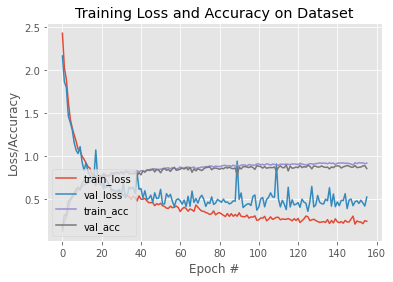

In [21]:
# plot the training loss and accuracy
N = len(history.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Experementing with Pytorch

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models
import torch
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
from torch.utils.data import random_split
import torchvision.transforms as transforms

In [ ]:
#checks if cuda is available on device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#splitting and normalizing data to have better control on the weights and prevent early overfitting
x_train, x_val, y_train, y_val = train_test_split(xs_raw["train"]/255,ys_raw)

In [ ]:
#converting the sets to tensors to be compatible with the model
y_train = tensor(y_train).to(torch.long)
x_train = tensor(x_train).to(torch.float)
x_val = tensor(x_val).to(torch.float)
y_val = tensor(y_val).to(torch.long)
#reshaping the data 
x_train = x_train.view(-1,3,128,128)
x_val = x_val.view(-1,3,128,128)

In [ ]:
x_train.shape, x_val.shape, y_train.shape ,y_val.shape

(torch.Size([3900, 3, 128, 128]),
 torch.Size([1300, 3, 128, 128]),
 torch.Size([3900]),
 torch.Size([1300]))

Our dataset is quite large and memory consuming so it won't fit in the avaiable memory, so we train the model in batches of size 32.

In [ ]:
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 2)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 2)

Fit function used to train the model, to test how our model truly performs we test it every iteration on the validation set this will give inforamtion about the true performance of the model since CNN are verry prone to overfitting.

In [ ]:
def fit(model, train_dl, val_dl, optimizer, epochs = 100, use_schedular = False, step_size = 10, gamma = 0.1):
    print(f'begin training for {type(model).__name__}')
    print(f'using {len(train_dl)} batches')
    #Dicts to store the performance metrics of the model
    accuracy_stats = {
        'train': [],
        "val": []
    }
    loss_stats = {
        'train': [],
        "val": []
    }
    #If we enable use schedular we can change learning rate during training this was implemented to use for optimizers that do not provide
    #the option like SGD later we use Adam who doesn't need this 
    if use_schedular : 
        step_lr_schedular = lr_scheduler.StepLR(optimizer, step_size=7,gamma = 0.1 )
    #training loop
    for epoch in tqdm(range(epochs)):
        
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        #iterating over every batch of our loader
        for X_train_batch, y_train_batch in train_dl:
            #moving the tensors to appropriate device to have optimal performance
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            #clearing the gradient : in Pytorch if we don't clear gradient it will increment based on the previous values which will give false gradients
            optimizer.zero_grad()
            #predictions 
            y_train_pred = model(X_train_batch)
            #computing the training loss
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)
            #computing the gradients using backpropagation
            train_loss.backward()
            #updating weigths 
            optimizer.step()
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
            
            
        # VALIDATION   
        # disabling requires grad on the tensors to avoid computing gradients that we don't need for the validation
        # It also prevents certain types of layers to not activate like dropout who have different behaviour between training and validating 
        with torch.no_grad(): 
            val_epoch_loss = 0
            val_epoch_acc = 0
            model.eval()
            for X_val_batch, y_val_batch in val_dl:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)            
                y_val_pred = model(X_val_batch)           
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)
                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
        if use_schedular : 
            step_lr_schedular.step()
        loss_stats['train'].append(train_epoch_loss/len(train_dl))
        loss_stats['val'].append(val_epoch_loss/len(val_dl))
        accuracy_stats['train'].append(train_epoch_acc/len(train_dl))
        accuracy_stats['val'].append(val_epoch_acc/len(val_dl))
                                
        
        print(f'Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len(train_dl):.5f} | Val Loss: {val_epoch_loss/len(val_dl):.5f} | Train Acc: {train_epoch_acc/len(train_dl):.3f}| Val Acc: {val_epoch_acc/len(val_dl):.3f}')
    return loss_stats, accuracy_stats

our model consists of 6 convulotinal layers paired with relu activation functions and maxpooling layers to reduce the outputs of our feature extraction layers that will be fed to the classifier

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self,):
        super(NeuralNet,self).__init__()
        self.network = nn.Sequential(
    
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(65536,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,13)
        )
    
    def forward(self, xb):
        return self.network(xb)
    

evaluating the model

In [ ]:
def eval(model, val_dl, y_val, show_stats):
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in val_dl:
            X_batch = X_batch.to(device)
            #predicting on the batch
            y_test_pred = model(X_batch)
            #taking the best prediction from the model
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    #transforming predictions to a list 
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    chain_object = itertools.chain.from_iterable(y_pred_list)
    y_pred= list(chain_object)
    if show_stats : 
        confusion_matrix_df = pd.DataFrame(confusion_matrix(y_val, y_pred))
        sns.heatmap(confusion_matrix_df, annot=True)
        print(classification_report(y_val, y_pred))
    return y_pred

In [ ]:
learning_rate = 0.001
epochs = 50

In [ ]:
model = NeuralNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() ,lr = learning_rate)

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    return acc

In [ ]:
loss_stats, accuracy_stats=  fit(model, train_dl, val_dl, optimizer, epochs)

Begin training.
Epoch 000: | Train Loss: 3.75844 | Val Loss: 2.54943 | Train Acc: 8.366| Val Acc: 10.643
Epoch 001: | Train Loss: 2.44339 | Val Loss: 2.26046 | Train Acc: 13.207| Val Acc: 18.857
Epoch 002: | Train Loss: 2.19791 | Val Loss: 2.11158 | Train Acc: 20.232| Val Acc: 22.500
Epoch 003: | Train Loss: 2.11703 | Val Loss: 2.17738 | Train Acc: 21.402| Val Acc: 22.286
Epoch 004: | Train Loss: 2.02187 | Val Loss: 1.80154 | Train Acc: 26.195| Val Acc: 36.071
Epoch 005: | Train Loss: 1.85326 | Val Loss: 1.71740 | Train Acc: 33.744| Val Acc: 37.786
Epoch 006: | Train Loss: 1.65837 | Val Loss: 1.64539 | Train Acc: 41.012| Val Acc: 40.000
Epoch 007: | Train Loss: 1.54057 | Val Loss: 1.47488 | Train Acc: 45.000| Val Acc: 48.357
Epoch 008: | Train Loss: 1.55467 | Val Loss: 1.58278 | Train Acc: 45.232| Val Acc: 44.143
Epoch 009: | Train Loss: 1.43868 | Val Loss: 1.39365 | Train Acc: 48.159| Val Acc: 51.929
Epoch 010: | Train Loss: 1.35929 | Val Loss: 1.55940 | Train Acc: 51.378| Val Acc: 45

In [ ]:
def display_accuary_loss(lstat,astat):
    train_val_acc_df = pd.DataFrame.from_dict(astat).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(lstat).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    # Plot the dataframes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

We can remark that our model is overfitting the training set 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

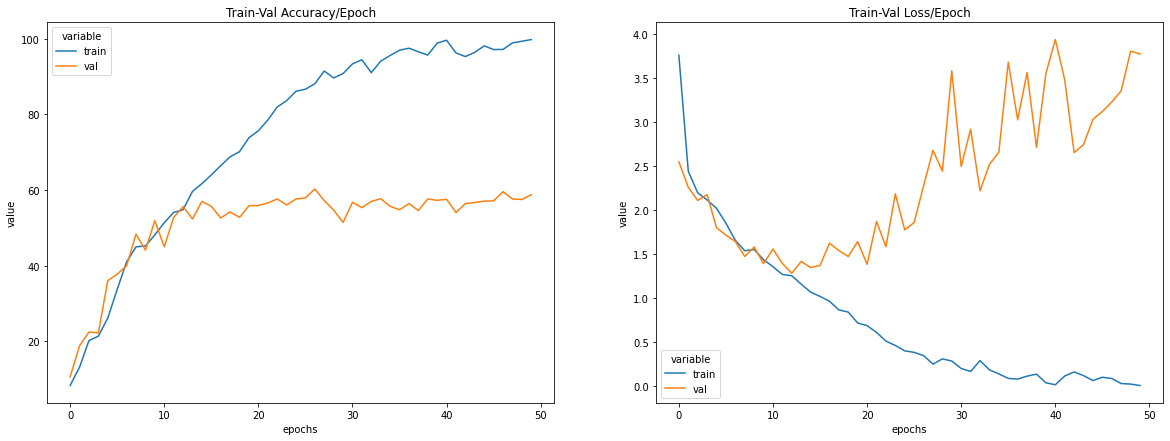

In [ ]:
# Create dataframes
display_accuary_loss(accuracy_stats, loss_stats)

<AxesSubplot:>

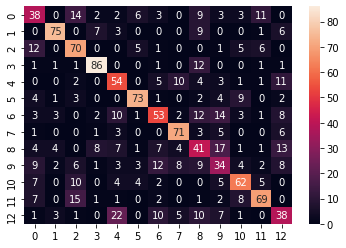

In [ ]:
y_pred = eval(model, val_dl,y_val, show_stats=True)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.42      0.43        91
           1       0.84      0.74      0.79       101
           2       0.57      0.70      0.63       100
           3       0.80      0.83      0.81       104
           4       0.50      0.59      0.54        91
           5       0.78      0.74      0.76        99
           6       0.55      0.47      0.51       112
           7       0.71      0.79      0.75        90
           8       0.37      0.38      0.37       108
           9       0.36      0.34      0.35       101
          10       0.64      0.63      0.63        99
          11       0.70      0.65      0.68       106
          12       0.41      0.39      0.40        98

    accuracy                           0.59      1300
   macro avg       0.59      0.59      0.59      1300
weighted avg       0.59      0.59      0.59      1300



# Data augmentation 

The idea behind data augmentation is to provide our model with more data to help the training process 
through different transformations on the existing set 

In [ ]:
from skimage.exposure import adjust_gamma 
from skimage.transform import rotate

In [ ]:
x_train_aug, x_val_aug, y_train_aug, y_val_aug= train_test_split(xs_raw["train"]/255,ys_raw,shuffle=True,random_state=42)

Our first approach is to add to the dataset different kinds of transformation of each image

In [ ]:
x_train_augmented = []
y_train_augmented = []

for i in tqdm(range(x_train.shape[0])):
    x_train_augmented.append(x_train_aug[i])
    x_train_augmented.append(rotate(x_train_aug[i],angle=np.random.randint(45,70),mode='wrap'))
    x_train_augmented.append(np.fliplr(x_train_aug[i]))
    x_train_augmented.append(np.flipud(x_train_aug[i]))
    x_train_augmented.append(adjust_gamma(x_train_aug[i], gamma=1.2, gain = 1))
    for j in range(5):
        y_train_augmented.append(y_train_aug[i])

100%|██████████| 3900/3900 [00:17<00:00, 227.13it/s]


dispalying the transforms on one picture

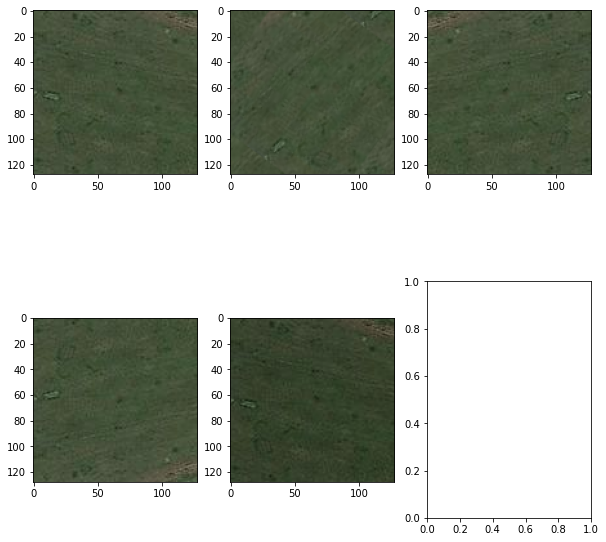

In [ ]:
NUM_TO_SHOW = 5

fig, axs_ = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
axs = axs_.flatten()

for i in range(NUM_TO_SHOW):
    img = x_train_augmented[i].reshape(128, 128, -1)
    axs[i].imshow(img)

plt.show()


In [ ]:
x_train_aug = np.asarray(x_train_augmented)
y_train_aug = np.asarray(y_train_augmented)

In [ ]:
x_train_aug.shape,y_train_aug.shape

((19500, 128, 128, 3), (19500,))

In [ ]:
y_train_aug = tensor(y_train_aug).to(torch.long)
x_train_aug= tensor(x_train_aug).to(torch.float)
x_val_aug = tensor(x_val_aug).to(torch.float)
y_val_aug = tensor(y_val_aug).to(torch.long)
x_train_aug = x_train_aug.view(-1,3,128,128)
x_val_aug = x_val_aug.view(-1,3,128,128)

In [ ]:
batch_size = 24
train_dataset_aug = TensorDataset(x_train_aug, y_train_aug)
val_dataset_aug= TensorDataset(x_val_aug, y_val_aug)
train_dl_aug = DataLoader(train_dataset_aug, batch_size, shuffle = True, num_workers = 4)
val_dl_aug = DataLoader(val_dataset_aug, batch_size*2, num_workers = 4)

In [ ]:
learning_rate = 0.001

In [ ]:
model_aug = NeuralNet()
model_aug = model_aug.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_aug.parameters() ,lr = learning_rate)

this time we managed to prevent early overfitting like last and improved our scores, the model's architecture however doesn't seem appropriate for the task we will proceed later to changing it  

In [ ]:
loss_aug, accuracy_aug = fit(model_aug, train_dl_aug, val_dl_aug, optimizer,  epochs = 30, use_schedular=False)

begin training for NeuralNet
using 325 batches


  3%|▎         | 1/30 [01:02<30:06, 62.30s/it]

Epoch 000: | Train Loss: 2.59956 | Val Loss: 2.13149 | Train Acc: 10.572| Val Acc: 21.357


  7%|▋         | 2/30 [02:01<28:09, 60.34s/it]

Epoch 001: | Train Loss: 2.22668 | Val Loss: 1.89427 | Train Acc: 18.698| Val Acc: 32.429


 10%|█         | 3/30 [03:00<26:53, 59.75s/it]

Epoch 002: | Train Loss: 1.88507 | Val Loss: 1.55641 | Train Acc: 32.729| Val Acc: 47.143


 13%|█▎        | 4/30 [03:59<25:44, 59.42s/it]

Epoch 003: | Train Loss: 1.65057 | Val Loss: 1.31638 | Train Acc: 41.178| Val Acc: 53.071


 17%|█▋        | 5/30 [04:58<24:43, 59.35s/it]

Epoch 004: | Train Loss: 1.49697 | Val Loss: 1.19195 | Train Acc: 46.686| Val Acc: 57.786


 20%|██        | 6/30 [05:57<23:42, 59.27s/it]

Epoch 005: | Train Loss: 1.39477 | Val Loss: 1.09565 | Train Acc: 50.680| Val Acc: 63.643


 23%|██▎       | 7/30 [06:56<22:43, 59.26s/it]

Epoch 006: | Train Loss: 1.29678 | Val Loss: 1.03270 | Train Acc: 54.178| Val Acc: 65.286


 27%|██▋       | 8/30 [07:55<21:43, 59.23s/it]

Epoch 007: | Train Loss: 1.23606 | Val Loss: 1.06238 | Train Acc: 56.483| Val Acc: 64.857


 30%|███       | 9/30 [08:53<20:35, 58.85s/it]

Epoch 008: | Train Loss: 1.13973 | Val Loss: 1.10572 | Train Acc: 59.729| Val Acc: 64.643


 33%|███▎      | 10/30 [09:52<19:32, 58.61s/it]

Epoch 009: | Train Loss: 1.05277 | Val Loss: 1.12796 | Train Acc: 62.778| Val Acc: 67.500


 37%|███▋      | 11/30 [10:48<18:19, 57.86s/it]

Epoch 010: | Train Loss: 0.96770 | Val Loss: 1.50283 | Train Acc: 65.443| Val Acc: 64.071


 40%|████      | 12/30 [11:43<17:07, 57.08s/it]

Epoch 011: | Train Loss: 0.88897 | Val Loss: 1.49406 | Train Acc: 68.846| Val Acc: 64.357


 43%|████▎     | 13/30 [12:38<16:00, 56.52s/it]

Epoch 012: | Train Loss: 0.82159 | Val Loss: 2.27774 | Train Acc: 71.163| Val Acc: 63.071


 47%|████▋     | 14/30 [13:33<14:58, 56.14s/it]

Epoch 013: | Train Loss: 0.79226 | Val Loss: 1.58592 | Train Acc: 72.240| Val Acc: 66.500


 50%|█████     | 15/30 [14:29<13:57, 55.86s/it]

Epoch 014: | Train Loss: 0.71914 | Val Loss: 2.14256 | Train Acc: 74.794| Val Acc: 61.429


 53%|█████▎    | 16/30 [15:25<13:02, 55.90s/it]

Epoch 015: | Train Loss: 0.70420 | Val Loss: 2.19431 | Train Acc: 75.698| Val Acc: 63.929


 57%|█████▋    | 17/30 [16:23<12:17, 56.76s/it]

Epoch 016: | Train Loss: 0.64172 | Val Loss: 2.23544 | Train Acc: 77.711| Val Acc: 63.357


 60%|██████    | 18/30 [17:22<11:29, 57.43s/it]

Epoch 017: | Train Loss: 0.56932 | Val Loss: 2.71238 | Train Acc: 80.185| Val Acc: 64.214


 63%|██████▎   | 19/30 [18:21<10:36, 57.89s/it]

Epoch 018: | Train Loss: 0.52904 | Val Loss: 2.52522 | Train Acc: 81.597| Val Acc: 64.286


 67%|██████▋   | 20/30 [19:21<09:42, 58.30s/it]

Epoch 019: | Train Loss: 0.51470 | Val Loss: 2.57290 | Train Acc: 82.212| Val Acc: 64.857


 70%|███████   | 21/30 [20:20<08:46, 58.53s/it]

Epoch 020: | Train Loss: 0.50621 | Val Loss: 3.01659 | Train Acc: 82.603| Val Acc: 58.929


 73%|███████▎  | 22/30 [21:19<07:49, 58.71s/it]

Epoch 021: | Train Loss: 0.47494 | Val Loss: 2.48282 | Train Acc: 83.680| Val Acc: 63.143


 77%|███████▋  | 23/30 [22:17<06:48, 58.39s/it]

Epoch 022: | Train Loss: 0.43560 | Val Loss: 2.85699 | Train Acc: 84.886| Val Acc: 63.500


 80%|████████  | 24/30 [23:15<05:49, 58.28s/it]

Epoch 023: | Train Loss: 0.46233 | Val Loss: 2.73565 | Train Acc: 84.074| Val Acc: 60.929


 83%|████████▎ | 25/30 [24:13<04:50, 58.19s/it]

Epoch 024: | Train Loss: 0.43931 | Val Loss: 3.72050 | Train Acc: 84.794| Val Acc: 58.357


 87%|████████▋ | 26/30 [25:10<03:52, 58.02s/it]

Epoch 025: | Train Loss: 0.48239 | Val Loss: 3.24441 | Train Acc: 83.726| Val Acc: 60.857


 90%|█████████ | 27/30 [26:05<02:51, 57.21s/it]

Epoch 026: | Train Loss: 0.40794 | Val Loss: 2.58633 | Train Acc: 85.640| Val Acc: 62.429


 93%|█████████▎| 28/30 [27:01<01:53, 56.75s/it]

Epoch 027: | Train Loss: 0.40816 | Val Loss: 2.92091 | Train Acc: 85.748| Val Acc: 64.286


 97%|█████████▋| 29/30 [27:57<00:56, 56.37s/it]

Epoch 028: | Train Loss: 0.42309 | Val Loss: 2.69047 | Train Acc: 85.335| Val Acc: 60.571


100%|██████████| 30/30 [28:52<00:00, 57.75s/it]

Epoch 029: | Train Loss: 0.44112 | Val Loss: 3.33483 | Train Acc: 84.809| Val Acc: 61.286


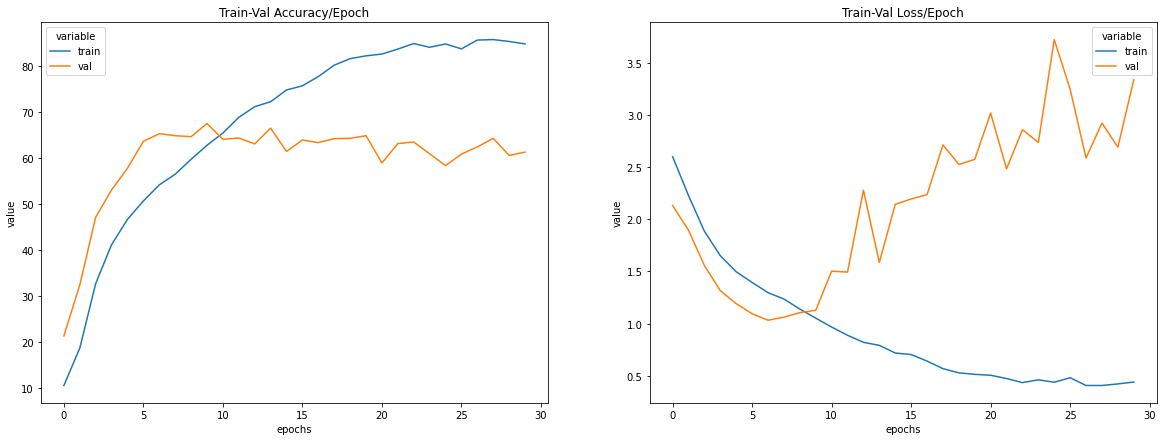

In [ ]:
display_accuary_loss(loss_aug, accuracy_aug)

              precision    recall  f1-score   support

           0       0.36      0.38      0.37       104
           1       0.85      0.67      0.75        94
           2       0.48      0.43      0.46        97
           3       0.71      0.81      0.76       108
           4       0.53      0.56      0.54        86
           5       0.67      0.74      0.70        99
           6       0.60      0.49      0.54       108
           7       0.75      0.72      0.73       102
           8       0.27      0.41      0.32        91
           9       0.29      0.31      0.30       113
          10       0.51      0.48      0.49       109
          11       0.62      0.45      0.53        88
          12       0.21      0.21      0.21       101

    accuracy                           0.51      1300
   macro avg       0.53      0.51      0.52      1300
weighted avg       0.53      0.51      0.51      1300



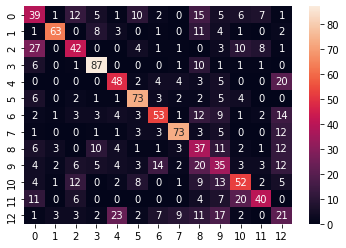

In [ ]:
y_pred_aug = eval(model_aug, val_dl_aug, y_val ,show_stats=True)

In [ ]:
FILE = "model_aug.pth"
torch.save(model_aug, FILE)

loading the model

In [ ]:
FILE = "model_aug.pth"
model_aug = torch.load(FILE)

# Transfer learning 

The idea of transfer learning is to take pretrained models(usually on datasets like imagenet) and their architechture and adapt it to the problem we're takling

Google net 

A first approach is to freeze all the layers and train only the classifier this will be much faster than tweaking the whole model but will probably yield worst results 

In [ ]:
from torchvision import models 
gnet_freeze = models.googlenet(pretrained=True)
num_ftrs = gnet_freeze.fc.in_features

In [ ]:
for param in gnet_freeze.parameters() : 
    param.requires_grad = False

In [ ]:
gnet_freeze.fc = nn.Linear(num_ftrs,13)
gnet_freeze = gnet_freeze.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gnet_freeze.parameters() ,lr = learning_rate)

In [ ]:
gnet_freeze_loss, gnet_freeze_accuracy = fit(gnet_freeze, train_dl_aug, val_dl_aug, optimizer, epochs = 30)

begin training for GoogLeNet
using 488 batches


  3%|▎         | 1/30 [00:12<06:06, 12.64s/it]

Epoch 000: | Train Loss: 2.05713 | Val Loss: 1.81574 | Train Acc: 43.436| Val Acc: 50.571


  7%|▋         | 2/30 [00:24<05:47, 12.42s/it]

Epoch 001: | Train Loss: 2.05347 | Val Loss: 2.03583 | Train Acc: 47.861| Val Acc: 49.286


 10%|█         | 3/30 [00:37<05:34, 12.38s/it]

Epoch 002: | Train Loss: 2.11753 | Val Loss: 1.75706 | Train Acc: 48.865| Val Acc: 53.524


 13%|█▎        | 4/30 [00:49<05:19, 12.29s/it]

Epoch 003: | Train Loss: 2.21938 | Val Loss: 1.91627 | Train Acc: 47.756| Val Acc: 53.238


 17%|█▋        | 5/30 [01:01<05:05, 12.23s/it]

Epoch 004: | Train Loss: 2.18424 | Val Loss: 1.73907 | Train Acc: 49.094| Val Acc: 53.476


 20%|██        | 6/30 [01:13<04:52, 12.21s/it]

Epoch 005: | Train Loss: 2.19468 | Val Loss: 1.74411 | Train Acc: 49.055| Val Acc: 54.286


 23%|██▎       | 7/30 [01:25<04:40, 12.19s/it]

Epoch 006: | Train Loss: 2.23176 | Val Loss: 1.86754 | Train Acc: 48.492| Val Acc: 52.286


 27%|██▋       | 8/30 [01:37<04:27, 12.17s/it]

Epoch 007: | Train Loss: 1.72469 | Val Loss: 1.43800 | Train Acc: 53.787| Val Acc: 56.667


 30%|███       | 9/30 [01:50<04:15, 12.16s/it]

Epoch 008: | Train Loss: 1.61019 | Val Loss: 1.37552 | Train Acc: 54.656| Val Acc: 57.667


 33%|███▎      | 10/30 [02:02<04:03, 12.16s/it]

Epoch 009: | Train Loss: 1.52634 | Val Loss: 1.29636 | Train Acc: 55.387| Val Acc: 58.238


 37%|███▋      | 11/30 [02:14<03:50, 12.15s/it]

Epoch 010: | Train Loss: 1.47785 | Val Loss: 1.29453 | Train Acc: 55.746| Val Acc: 57.762


 40%|████      | 12/30 [02:26<03:38, 12.15s/it]

Epoch 011: | Train Loss: 1.44476 | Val Loss: 1.27181 | Train Acc: 56.203| Val Acc: 58.190


 43%|████▎     | 13/30 [02:38<03:26, 12.14s/it]

Epoch 012: | Train Loss: 1.42158 | Val Loss: 1.26156 | Train Acc: 56.209| Val Acc: 57.619


 47%|████▋     | 14/30 [02:50<03:14, 12.14s/it]

Epoch 013: | Train Loss: 1.39746 | Val Loss: 1.23022 | Train Acc: 56.246| Val Acc: 57.857


 50%|█████     | 15/30 [03:02<03:02, 12.13s/it]

Epoch 014: | Train Loss: 1.32633 | Val Loss: 1.18983 | Train Acc: 57.607| Val Acc: 59.476


 53%|█████▎    | 16/30 [03:15<02:49, 12.13s/it]

Epoch 015: | Train Loss: 1.34193 | Val Loss: 1.20773 | Train Acc: 56.934| Val Acc: 58.381


 57%|█████▋    | 17/30 [03:27<02:37, 12.13s/it]

Epoch 016: | Train Loss: 1.32080 | Val Loss: 1.21528 | Train Acc: 57.773| Val Acc: 59.000


 60%|██████    | 18/30 [03:39<02:25, 12.15s/it]

Epoch 017: | Train Loss: 1.33217 | Val Loss: 1.22299 | Train Acc: 57.066| Val Acc: 58.714


 63%|██████▎   | 19/30 [03:51<02:13, 12.16s/it]

Epoch 018: | Train Loss: 1.30460 | Val Loss: 1.20417 | Train Acc: 58.018| Val Acc: 59.952


 67%|██████▋   | 20/30 [04:03<02:01, 12.15s/it]

Epoch 019: | Train Loss: 1.32046 | Val Loss: 1.20484 | Train Acc: 57.402| Val Acc: 58.952


 70%|███████   | 21/30 [04:15<01:49, 12.14s/it]

Epoch 020: | Train Loss: 1.31429 | Val Loss: 1.17602 | Train Acc: 57.547| Val Acc: 58.857


 73%|███████▎  | 22/30 [04:27<01:37, 12.15s/it]

Epoch 021: | Train Loss: 1.30230 | Val Loss: 1.19375 | Train Acc: 57.529| Val Acc: 59.571


 77%|███████▋  | 23/30 [04:40<01:25, 12.18s/it]

Epoch 022: | Train Loss: 1.29752 | Val Loss: 1.19505 | Train Acc: 58.064| Val Acc: 59.429


 80%|████████  | 24/30 [04:52<01:12, 12.16s/it]

Epoch 023: | Train Loss: 1.31665 | Val Loss: 1.19362 | Train Acc: 57.283| Val Acc: 59.476


 83%|████████▎ | 25/30 [05:04<01:00, 12.15s/it]

Epoch 024: | Train Loss: 1.29717 | Val Loss: 1.19373 | Train Acc: 58.020| Val Acc: 59.429


 87%|████████▋ | 26/30 [05:16<00:48, 12.16s/it]

Epoch 025: | Train Loss: 1.30322 | Val Loss: 1.19014 | Train Acc: 57.982| Val Acc: 60.095


 90%|█████████ | 27/30 [05:28<00:36, 12.15s/it]

Epoch 026: | Train Loss: 1.29533 | Val Loss: 1.21080 | Train Acc: 58.094| Val Acc: 58.762


 93%|█████████▎| 28/30 [05:40<00:24, 12.14s/it]

Epoch 027: | Train Loss: 1.29388 | Val Loss: 1.21316 | Train Acc: 58.230| Val Acc: 59.286


 97%|█████████▋| 29/30 [05:52<00:12, 12.13s/it]

Epoch 028: | Train Loss: 1.30279 | Val Loss: 1.20658 | Train Acc: 57.822| Val Acc: 58.048


100%|██████████| 30/30 [06:05<00:00, 12.17s/it]

Epoch 029: | Train Loss: 1.28176 | Val Loss: 1.19731 | Train Acc: 58.125| Val Acc: 59.238


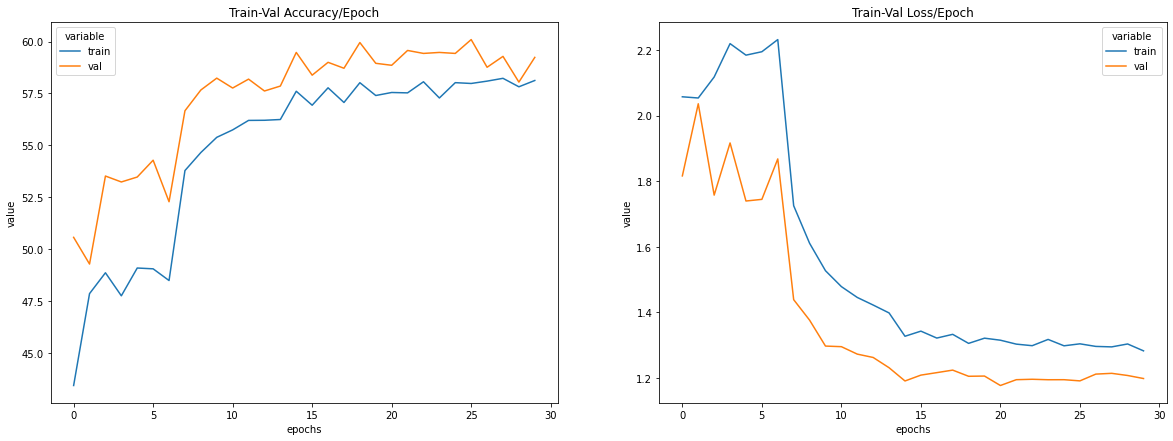

In [ ]:
display_accuary_loss(gnet_freeze_loss, gnet_freeze_accuracy)

Now we will proceed with tweaking the whole parameters of the model 

In [ ]:
gnet = models.googlenet(pretrained=True)
num_ftrs = gnet.fc.in_features

In [ ]:
gnet.fc = nn.Linear(num_ftrs,13)
gnet = gnet.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gnet.parameters() ,lr = 0.001)

In [ ]:
gnet_loss, gnet_accuracy = fit(gnet, train_dl_aug, val_dl_aug, optimizer, epochs = 20)

begin training for GoogLeNet
using 407 batches


  5%|▌         | 1/20 [00:33<10:43, 33.88s/it]

Epoch 000: | Train Loss: 1.15634 | Val Loss: 0.95051 | Train Acc: 61.609| Val Acc: 67.357


 10%|█         | 2/20 [01:07<10:09, 33.84s/it]

Epoch 001: | Train Loss: 0.78628 | Val Loss: 0.87356 | Train Acc: 73.904| Val Acc: 69.643


 15%|█▌        | 3/20 [01:41<09:35, 33.83s/it]

Epoch 002: | Train Loss: 0.64277 | Val Loss: 1.13057 | Train Acc: 78.270| Val Acc: 62.429


 20%|██        | 4/20 [02:15<09:01, 33.83s/it]

Epoch 003: | Train Loss: 0.50929 | Val Loss: 0.70827 | Train Acc: 82.607| Val Acc: 77.000


 25%|██▌       | 5/20 [02:49<08:28, 33.92s/it]

Epoch 004: | Train Loss: 0.43533 | Val Loss: 0.63603 | Train Acc: 85.629| Val Acc: 78.714


 30%|███       | 6/20 [03:23<07:56, 34.04s/it]

Epoch 005: | Train Loss: 0.36038 | Val Loss: 0.72762 | Train Acc: 87.732| Val Acc: 77.071


 35%|███▌      | 7/20 [03:57<07:21, 33.93s/it]

Epoch 006: | Train Loss: 0.32216 | Val Loss: 0.85571 | Train Acc: 88.990| Val Acc: 74.500


 40%|████      | 8/20 [04:30<06:45, 33.82s/it]

Epoch 007: | Train Loss: 0.26710 | Val Loss: 0.75874 | Train Acc: 91.229| Val Acc: 77.357


 45%|████▌     | 9/20 [05:03<06:08, 33.52s/it]

Epoch 008: | Train Loss: 0.23205 | Val Loss: 0.71741 | Train Acc: 92.197| Val Acc: 78.786


 50%|█████     | 10/20 [05:36<05:33, 33.38s/it]

Epoch 009: | Train Loss: 0.20276 | Val Loss: 0.82494 | Train Acc: 93.256| Val Acc: 78.000


 55%|█████▌    | 11/20 [06:09<04:57, 33.00s/it]

Epoch 010: | Train Loss: 0.17542 | Val Loss: 0.67127 | Train Acc: 94.295| Val Acc: 82.214


 60%|██████    | 12/20 [06:41<04:22, 32.83s/it]

Epoch 011: | Train Loss: 0.15220 | Val Loss: 0.84453 | Train Acc: 95.187| Val Acc: 78.286


 65%|██████▌   | 13/20 [07:14<03:49, 32.76s/it]

Epoch 012: | Train Loss: 0.14877 | Val Loss: 0.97271 | Train Acc: 94.931| Val Acc: 77.214


 70%|███████   | 14/20 [07:49<03:20, 33.49s/it]

Epoch 013: | Train Loss: 0.12794 | Val Loss: 0.94580 | Train Acc: 95.875| Val Acc: 75.786


 75%|███████▌  | 15/20 [08:21<02:46, 33.22s/it]

Epoch 014: | Train Loss: 0.12809 | Val Loss: 1.02758 | Train Acc: 95.816| Val Acc: 76.429


 80%|████████  | 16/20 [08:54<02:11, 32.94s/it]

Epoch 015: | Train Loss: 0.11432 | Val Loss: 0.86567 | Train Acc: 96.268| Val Acc: 79.286


 85%|████████▌ | 17/20 [09:26<01:38, 32.89s/it]

Epoch 016: | Train Loss: 0.10635 | Val Loss: 0.94571 | Train Acc: 96.432| Val Acc: 77.429


 90%|█████████ | 18/20 [10:00<01:06, 33.04s/it]

Epoch 017: | Train Loss: 0.10317 | Val Loss: 0.85610 | Train Acc: 96.784| Val Acc: 79.143


 95%|█████████▌| 19/20 [10:32<00:32, 32.90s/it]

Epoch 018: | Train Loss: 0.08868 | Val Loss: 1.05348 | Train Acc: 97.029| Val Acc: 76.786


100%|██████████| 20/20 [11:05<00:00, 33.26s/it]

Epoch 019: | Train Loss: 0.10680 | Val Loss: 0.87443 | Train Acc: 96.570| Val Acc: 79.429


Accuracy improved over the original model but we faced overfitting for the next models we will add regularizition to our model through wight decay on our optimizer (L2 regularization)

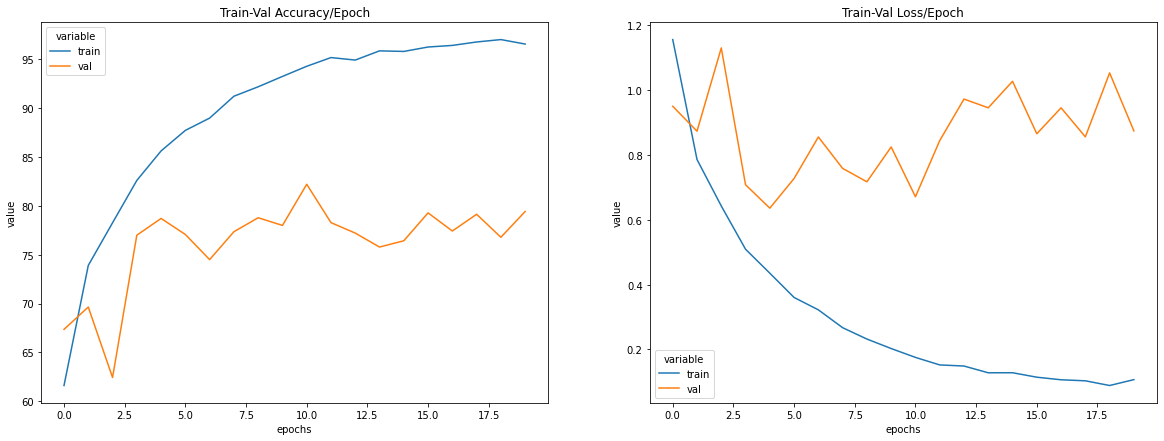

In [ ]:
display_accuary_loss(gnet_loss, gnet_accuracy)

DENSENET

In [ ]:
densenet = models.densenet121(pretrained=True)

densenet.classifier= nn.Sequential(
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,13))
densenet = densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters() ,lr = 0.001)

In [ ]:
dens_loss, dense_acc = fit(densenet, train_dl_aug, val_dl_aug, optimizer, epochs=20)

begin training for DenseNet
using 325 batches


  5%|▌         | 1/20 [01:13<23:09, 73.15s/it]

Epoch 000: | Train Loss: 1.14077 | Val Loss: 0.98579 | Train Acc: 62.308| Val Acc: 69.786


 10%|█         | 2/20 [02:23<21:31, 71.73s/it]

Epoch 001: | Train Loss: 0.73989 | Val Loss: 0.95076 | Train Acc: 75.615| Val Acc: 68.929


 15%|█▌        | 3/20 [03:34<20:10, 71.19s/it]

Epoch 002: | Train Loss: 0.59600 | Val Loss: 0.84588 | Train Acc: 80.302| Val Acc: 73.071


 20%|██        | 4/20 [04:45<18:55, 70.95s/it]

Epoch 003: | Train Loss: 0.52211 | Val Loss: 0.78571 | Train Acc: 82.289| Val Acc: 75.071


 25%|██▌       | 5/20 [05:55<17:40, 70.69s/it]

Epoch 004: | Train Loss: 0.45530 | Val Loss: 0.58564 | Train Acc: 84.717| Val Acc: 81.000


 30%|███       | 6/20 [07:01<16:06, 69.04s/it]

Epoch 005: | Train Loss: 0.40655 | Val Loss: 0.52307 | Train Acc: 86.148| Val Acc: 83.071


 35%|███▌      | 7/20 [08:06<14:40, 67.71s/it]

Epoch 006: | Train Loss: 0.34960 | Val Loss: 0.60848 | Train Acc: 88.145| Val Acc: 80.500


 40%|████      | 8/20 [09:11<13:22, 66.85s/it]

Epoch 007: | Train Loss: 0.31831 | Val Loss: 0.71689 | Train Acc: 89.314| Val Acc: 77.643


 45%|████▌     | 9/20 [10:17<12:14, 66.74s/it]

Epoch 008: | Train Loss: 0.28036 | Val Loss: 0.81284 | Train Acc: 90.237| Val Acc: 77.571


 50%|█████     | 10/20 [11:26<11:13, 67.31s/it]

Epoch 009: | Train Loss: 0.25968 | Val Loss: 0.80443 | Train Acc: 91.323| Val Acc: 77.357


 55%|█████▌    | 11/20 [12:34<10:09, 67.72s/it]

Epoch 010: | Train Loss: 0.22466 | Val Loss: 0.79018 | Train Acc: 92.757| Val Acc: 78.714


 60%|██████    | 12/20 [13:44<09:05, 68.19s/it]

Epoch 011: | Train Loss: 0.21513 | Val Loss: 0.73182 | Train Acc: 93.077| Val Acc: 80.143


 65%|██████▌   | 13/20 [14:54<08:03, 69.01s/it]

Epoch 012: | Train Loss: 0.19937 | Val Loss: 0.73705 | Train Acc: 93.585| Val Acc: 80.714


 70%|███████   | 14/20 [16:01<06:49, 68.32s/it]

Epoch 013: | Train Loss: 0.17898 | Val Loss: 0.59754 | Train Acc: 94.249| Val Acc: 83.143


 75%|███████▌  | 15/20 [17:08<05:39, 67.90s/it]

Epoch 014: | Train Loss: 0.15084 | Val Loss: 0.66452 | Train Acc: 94.926| Val Acc: 82.714


 80%|████████  | 16/20 [18:16<04:31, 67.90s/it]

Epoch 015: | Train Loss: 0.16081 | Val Loss: 0.84613 | Train Acc: 94.658| Val Acc: 80.357


 85%|████████▌ | 17/20 [19:26<03:25, 68.59s/it]

Epoch 016: | Train Loss: 0.15101 | Val Loss: 0.74946 | Train Acc: 95.191| Val Acc: 80.857


 90%|█████████ | 18/20 [20:35<02:17, 68.57s/it]

Epoch 017: | Train Loss: 0.14839 | Val Loss: 0.72053 | Train Acc: 95.348| Val Acc: 82.357


 95%|█████████▌| 19/20 [21:40<01:07, 67.67s/it]

Epoch 018: | Train Loss: 0.12026 | Val Loss: 1.27584 | Train Acc: 96.182| Val Acc: 74.786


100%|██████████| 20/20 [22:46<00:00, 68.30s/it]

Epoch 019: | Train Loss: 0.11769 | Val Loss: 0.65539 | Train Acc: 96.394| Val Acc: 83.357


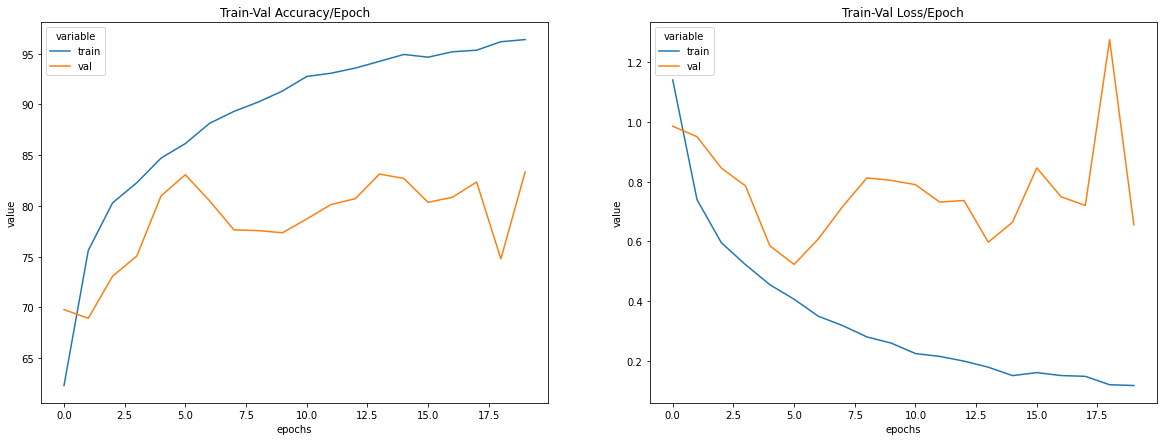

In [ ]:
display_accuary_loss(dens_loss, dense_acc)

    ResNet50

In [ ]:
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features

resnet50.fc = nn.Linear(num_ftrs,13)
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters() ,lr = 0.001)

In [ ]:
resnet50_loss, resnet50_acc = fit(resnet50, train_dl_aug, val_dl_aug, optimizer, epochs=20)

begin training for ResNet
using 813 batches


  5%|▌         | 1/20 [01:34<29:53, 94.37s/it]

Epoch 000: | Train Loss: 1.18957 | Val Loss: 0.86537 | Train Acc: 60.487| Val Acc: 68.893


 10%|█         | 2/20 [03:00<26:46, 89.25s/it]

Epoch 001: | Train Loss: 0.81064 | Val Loss: 0.79481 | Train Acc: 72.528| Val Acc: 72.214


 15%|█▌        | 3/20 [04:25<24:48, 87.58s/it]

Epoch 002: | Train Loss: 0.65619 | Val Loss: 0.73052 | Train Acc: 77.638| Val Acc: 74.964


 20%|██        | 4/20 [05:51<23:09, 86.81s/it]

Epoch 003: | Train Loss: 0.53809 | Val Loss: 0.63932 | Train Acc: 81.374| Val Acc: 78.571


 25%|██▌       | 5/20 [07:16<21:35, 86.36s/it]

Epoch 004: | Train Loss: 0.46820 | Val Loss: 0.87312 | Train Acc: 84.149| Val Acc: 73.143


 30%|███       | 6/20 [08:41<20:02, 85.86s/it]

Epoch 005: | Train Loss: 0.41567 | Val Loss: 0.76259 | Train Acc: 86.130| Val Acc: 74.536


 35%|███▌      | 7/20 [10:04<18:22, 84.78s/it]

Epoch 006: | Train Loss: 0.33818 | Val Loss: 0.69327 | Train Acc: 88.358| Val Acc: 78.464


 40%|████      | 8/20 [11:28<16:54, 84.50s/it]

Epoch 007: | Train Loss: 0.15529 | Val Loss: 0.46758 | Train Acc: 95.311| Val Acc: 84.357


 45%|████▌     | 9/20 [12:51<15:27, 84.28s/it]

Epoch 008: | Train Loss: 0.09749 | Val Loss: 0.48611 | Train Acc: 97.129| Val Acc: 84.679


 50%|█████     | 10/20 [14:13<13:53, 83.35s/it]

Epoch 009: | Train Loss: 0.06877 | Val Loss: 0.51067 | Train Acc: 98.106| Val Acc: 84.679


 55%|█████▌    | 11/20 [15:34<12:24, 82.73s/it]

Epoch 010: | Train Loss: 0.04862 | Val Loss: 0.52942 | Train Acc: 98.601| Val Acc: 84.929


 60%|██████    | 12/20 [16:57<11:02, 82.81s/it]

Epoch 011: | Train Loss: 0.04036 | Val Loss: 0.57270 | Train Acc: 98.887| Val Acc: 83.536


 65%|██████▌   | 13/20 [18:19<09:38, 82.57s/it]

Epoch 012: | Train Loss: 0.02820 | Val Loss: 0.68455 | Train Acc: 99.326| Val Acc: 82.893


 70%|███████   | 14/20 [19:40<08:13, 82.22s/it]

Epoch 013: | Train Loss: 0.02351 | Val Loss: 0.62712 | Train Acc: 99.413| Val Acc: 83.607


 75%|███████▌  | 15/20 [21:01<06:48, 81.74s/it]

Epoch 014: | Train Loss: 0.01899 | Val Loss: 0.62616 | Train Acc: 99.533| Val Acc: 83.857


 80%|████████  | 16/20 [22:23<05:26, 81.71s/it]

Epoch 015: | Train Loss: 0.01554 | Val Loss: 0.62025 | Train Acc: 99.656| Val Acc: 84.071


 85%|████████▌ | 17/20 [23:44<04:04, 81.51s/it]

Epoch 016: | Train Loss: 0.01402 | Val Loss: 0.65005 | Train Acc: 99.720| Val Acc: 84.107


 90%|█████████ | 18/20 [25:06<02:43, 81.66s/it]

Epoch 017: | Train Loss: 0.01237 | Val Loss: 0.62520 | Train Acc: 99.753| Val Acc: 83.929


 95%|█████████▌| 19/20 [26:28<01:21, 81.73s/it]

Epoch 018: | Train Loss: 0.01268 | Val Loss: 0.64368 | Train Acc: 99.748| Val Acc: 83.464


100%|██████████| 20/20 [27:50<00:00, 83.54s/it]

Epoch 019: | Train Loss: 0.01061 | Val Loss: 0.65091 | Train Acc: 99.779| Val Acc: 84.429


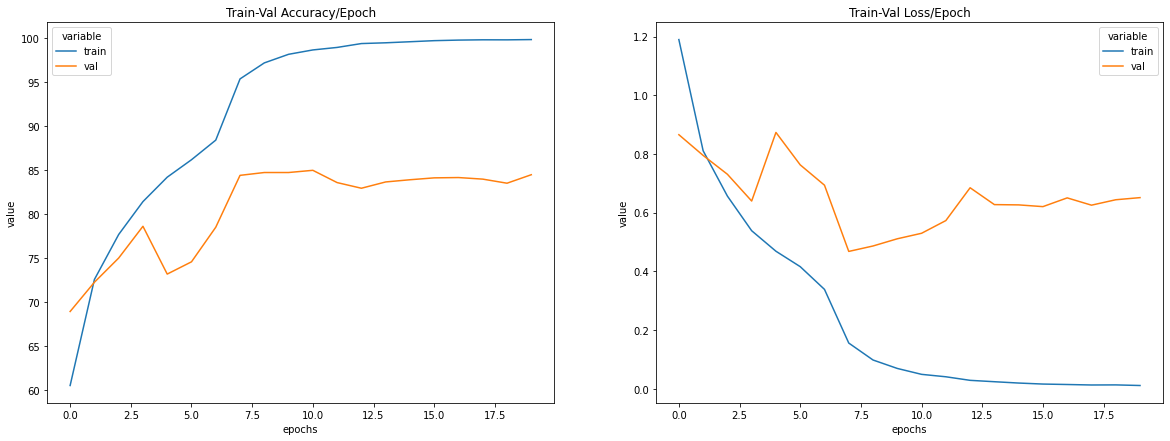

In [ ]:
display_accuary_loss(resnet50_loss, resnet50_acc)

At last we will implement a custom data loader to better integrate with pytorch. A custom data loader will be able to take as an argument A list of transforms that can be applied to the data when it's fed to the CNN for training. Thus transforming at random our data.

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomTensorDataset(Dataset):
  def __init__(self, dataset, transform_list=None):
    [data_X, data_y] = dataset
    
    tensors = (data_X, data_y)
  
    self.tensors = tensors
    self.transforms = transform_list

  def __getitem__(self, index):
    x = self.tensors[0][index]

    if self.transforms:
      x = self.transforms(x)

    y = self.tensors[1][index]

    return x, y

  def __len__(self):
    return self.tensors[0].size(0)
  
  

In [ ]:
y_train_imp = y_train
x_train_imp = x_train
x_val_imp = x_val
y_val_imp = y_val
x_train_imp = x_train.view(-1,3,128,128)
x_val_imp = x_valview(-1,3,128,128)

C:\Users\Fedy\AppData\Local\Temp/ipykernel_9724/374198941.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_imp = tensor(y_train_aug).to(torch.long)
C:\Users\Fedy\AppData\Local\Temp/ipykernel_9724/374198941.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_imp = tensor(x_train_aug).to(torch.float)
C:\Users\Fedy\AppData\Local\Temp/ipykernel_9724/374198941.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_imp = tensor(x_val_aug).to(torch.float)
C:\Users\Fedy\AppData\Local\Temp/ipykernel_9724/374198941.py:4: UserW

defining of data loaders

In [ ]:
train_dataset = CustomTensorDataset([x_train_imp, y_train_imp], transform_list = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
]))

In [ ]:
dataset_val =  CustomTensorDataset([x_val_imp, y_val_imp])

train_dl_imp = DataLoader(train_dataset, batch_size=48, shuffle = True)
val_dl_imp = DataLoader(dataset_val,batch_size=48)